Purpose: Set a threshold for extraction of top predictors via iterative feature removal and re-running of random forest (genes-as-features) for each stressor. Following this, extract top predictors using determined set sizes and find overlap.<br>
Author: Anna Pardo<br>
Date initiated: August 10, 2023

In [1]:
# load modules
import pandas as pd
import statistics
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
import json
from sklearn.metrics import f1_score

In [5]:
def load_clean_data(path_to_tpm):
    """
    Args:
        path_to_tpm = full path to file containing raw TPM, columns for Sample, BioProject, & Treatment
        single_stress = a single stressor to which the data must be subsetted, or "none" (default)
    """
    # load the TPM data
    raw_tpm = pd.read_csv(path_to_tpm,sep="\t",header="infer")
    # replace DroughtRepeat with Drought
    raw_tpm["Treatment"].mask(raw_tpm["Treatment"]=="DroughtRepeat","Drought",inplace=True)
    # labeling: set Control to 0 and stressors to 1-6
    proxy = []
    for i in range(len(raw_tpm.index)):
        if raw_tpm.iloc[i,raw_tpm.columns.get_loc("Treatment")] == "Control":
            proxy.append(0)
        else:
            proxy.append(1)
    raw_tpm["Label"] = proxy
    # return the dataframe
    return raw_tpm

In [7]:
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [8]:
def downsample(dataframe):
    """
    Args:
        dataframe = a log TPM dataframe with a Label column and Sample set as the index
    """
    # generate a variable of value counts
    vc = dataframe["Label"].value_counts()

    # subset data to only samples labeled 1
    ones_only = dataframe[dataframe["Label"]==1]

    # downsample from the subsetted dataframe
    ds = ones_only.sample(n=vc[1],random_state=42)

    # subset original data to control samples
    zeroes = dataframe[dataframe["Label"]==0]

    # concatenate controls and downsampled stress samples
    downsampled = pd.concat([ds,zeroes])
    # return dataframe
    return downsampled

In [9]:
def pre_split_transform(raw_tpm,balanced,downsample=False):
    """
    Args:
        raw_tpm = dataframe containing raw TPM values, columns for Sample, BioProject, Treatment, Label
        balanced = Boolean variable, True or False (result of check_if_balanced())
        downsample = Boolean variable, True or False, default False (set manually outside function)
    """
    # if data have treatment column, drop it
    #if "Treatment" in raw_tpm.columns:
    #    raw_tpm = raw_tpm.drop("Treatment",axis=1)
    # temporarily, set index to Sample and drop BioProject, Label, & Treatment columns
    blt = raw_tpm[["Sample","BioProject","Treatment","Label"]]
    tpmi = raw_tpm.set_index("Sample").drop(["BioProject","Treatment","Label"],axis=1)
    # remove zero-variance genes
    vttpm = variance_threshold_selector(tpmi)
    # log-transform TPM
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    # downsample data if needed
    if balanced!=True:
        if downsample==True:
            # add back labels
            vttpm_log = blt[["Sample","Label"]].merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
            # set Sample as index
            vttpm_log = vttpm_log.set_index("Sample")
            # downsample the data
            vttpm_log = downsample(vttpm_log)
    # add treatment, labels, and BioProject back in, set Sample as the index again
    labeled = blt.merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
    labeled.set_index("Sample",inplace=True)
    # drop rows containing NaN values
    labeled = labeled.dropna(axis=0)
    # return dataframe
    return labeled

In [12]:
def split_prep_stressor(stressor,dataframe,balance="Up"):
    """
    Args:
        stressor = stressor to hold out for testing (all BioProjects)
        dataframe = log TPM dataframe with Sample, Label, BioProject, Treatment columns (or Sample as index)
        balance = str: "none","up" (downsampling will be done before splitting, outside of this function)
    """
    # in case Sample isn't already a column, reset the index and rename the column to Sample
    if "Sample" not in dataframe.columns:
        dataframe = dataframe.reset_index().rename(columns={"index":"Sample"})
    # generate list of unique BioProjects containing the test stressor
    sbp = dataframe[dataframe["Treatment"]==stressor]["BioProject"].unique()
    # split test from train data
    test = dataframe[dataframe["BioProject"].isin(sbp)]
    test = test[test["Treatment"].isin([stressor,"Control"])]
    # pull out training data
    train = dataframe[~dataframe["Sample"].isin(test["Sample"])]
    # for both sets, make Sample the index again
    test = test.set_index("Sample")
    train = train.set_index("Sample")
    # drop BioProject and Treatment columns from both sets
    test = test.drop(["BioProject","Treatment"],axis=1)
    train = train.drop(["BioProject","Treatment"],axis=1)
    # generate X_train, X_test, y_train, and y_test
    ## where X = gene expression values and y = class labels
    train_X = train.drop("Label",axis=1)
    y_train = train["Label"]
    test_X = test.drop("Label",axis=1)
    y_test = test["Label"]
    # if upsampling: do the upsampling using SMOTE
    if balance=="Up":
        sm = SMOTE(random_state=42)
        train_X, y_train = sm.fit_resample(train_X,y_train)
    # for X_train and X_test: scale data to a z-score
    scalar = StandardScaler()
    X_train = scalar.fit_transform(train_X)
    X_test = scalar.fit_transform(test_X)
    # return training and test data
    return X_train, y_train, X_test, y_test

In [23]:
# write a function to do the iterative stepwise feature removal and return a dataframe of the accuracy, F1 for each class,
## and number of top features included
def rf_iterative(stressor,tpmdf,fidf,max_important_features,stepsize,hypdict):
    # subset the feature importance dataframe to the top n features, where n=max_important_features (int)
    topmax = fidf.head(n=max_important_features)
    
    # initiate classifier
    rfc = RandomForestClassifier(bootstrap=hypdict["bootstrap"],
                                ccp_alpha=hypdict["ccp_alpha"],
                                class_weight=hypdict["class_weight"],
                                criterion=hypdict["criterion"],
                                max_depth=hypdict["max_depth"],
                                max_features=hypdict["max_features"],
                                max_leaf_nodes=hypdict["max_leaf_nodes"],
                                max_samples=hypdict["max_samples"],
                                min_impurity_decrease=hypdict["min_impurity_decrease"],
                                min_samples_leaf=hypdict["min_samples_leaf"],
                                min_samples_split=hypdict["min_samples_split"],
                                min_weight_fraction_leaf=hypdict["min_weight_fraction_leaf"],
                                n_estimators=hypdict["n_estimators"],
                                n_jobs=hypdict["n_jobs"],
                                oob_score=hypdict["oob_score"],
                                random_state=hypdict["random_state"],
                                verbose=hypdict["verbose"],
                                warm_start=hypdict["warm_start"])
    
    # run the random forest iteratively, saving the scores each time
    setsizes = []
    accuracy = []
    f1_class0 = []
    f1_class1 = []
    for i in range(stepsize,max_important_features,stepsize):
        # append set size to list
        setsizes.append(max_important_features-i)
        # pull out the i least important genes
        leastgenes = list(topmax.tail(n=i)["GeneID"])
        # drop these genes from the TPM dataframe (not yet transformed)
        subtpm = tpmdf.drop(leastgenes,axis=1)
        # transform the data
        transtpm = pre_split_transform(subtpm,False,False)
        # split the train and test sets
        X_train, y_train, X_test, y_test = split_prep_stressor(stressor,transtpm,"Up")
        # fit model on training data
        rfc.fit(X_train,y_train)
        # make predictions on test set
        y_pred = rfc.predict(X_test)
        # generate scores and save into lists
        accuracy.append(accuracy_score(y_test,y_pred))
        f1 = list(f1_score(y_test,y_pred,average=None))
        f1_class0.append(f1[0])
        f1_class1.append(f1[1])
    
    # stick lists together into a dataframe
    setsize_scores = pd.DataFrame(list(zip(setsizes,accuracy,f1_class0,f1_class1)),columns=["Set Size","Accuracy","F1 Control",
                                                                                           "F1 Stressed"])
    return setsize_scores

In [21]:
list(coldhyp.keys())

['bootstrap',
 'ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [4]:
# start with the model for cold
# load model hyperparameters
coldhyp = json.load(open("../../data/rf_outputs/upsample_13-Jul-2023/ColdTest_fixedscript_Up_output/ColdTest_fixedscript_Up_Hyperparameters.json"))

In [6]:
# load TPM
tpm = load_clean_data("../../data/rawtpm_bptreat_noPEG.tsv")

In [10]:
transformed = pre_split_transform(tpm,False,False)

In [13]:
X_train, y_train, X_test, y_test = split_prep_stressor("Cold",transformed,"Up")

In [16]:
# load feature importance from cold model
fi = pd.read_csv("../../data/rf_outputs/upsample_13-Jul-2023/ColdTest_fixedscript_Up_output/ColdTest_fixedscript_Up_Feature_Importances_sorted.tsv",
                sep="\t",header="infer")

In [ ]:
cold_sets_scores = rf_iterative("Cold",tpm,fi,5000,50,coldhyp)

In [1]:
# make txt files of the hyperparameters & feature importances, in the same order as the txt file of stressors
stressorlist = ["Drought","Heat","Salt","Cold","Flooding","Low_Nitrogen"]

In [3]:
directory = "/mnt/research/VanBuren_Lab/02_users/Anna_Haber/core-stress-transcriptome/01_data/core_stress_random_forest/upsample_13-Jul-2023/"

In [5]:
hyperlist = []
filist = []
for s in stressorlist:
    newdir = directory+s+"Test_fixedscript_Up_output/"
    filist.append(newdir+s+"Test_fixedscript_Up_Feature_Importances_sorted.tsv")
    hyperlist.append(newdir+s+"Test_fixedscript_Up_Hyperparameters.json")

In [6]:
hyperlist

['/mnt/research/VanBuren_Lab/02_users/Anna_Haber/core-stress-transcriptome/01_data/core_stress_random_forest/upsample_13-Jul-2023/DroughtTest_fixedscript_Up_output/DroughtTest_fixedscript_Up_Hyperparameters.json',
 '/mnt/research/VanBuren_Lab/02_users/Anna_Haber/core-stress-transcriptome/01_data/core_stress_random_forest/upsample_13-Jul-2023/HeatTest_fixedscript_Up_output/HeatTest_fixedscript_Up_Hyperparameters.json',
 '/mnt/research/VanBuren_Lab/02_users/Anna_Haber/core-stress-transcriptome/01_data/core_stress_random_forest/upsample_13-Jul-2023/SaltTest_fixedscript_Up_output/SaltTest_fixedscript_Up_Hyperparameters.json',
 '/mnt/research/VanBuren_Lab/02_users/Anna_Haber/core-stress-transcriptome/01_data/core_stress_random_forest/upsample_13-Jul-2023/ColdTest_fixedscript_Up_output/ColdTest_fixedscript_Up_Hyperparameters.json',
 '/mnt/research/VanBuren_Lab/02_users/Anna_Haber/core-stress-transcriptome/01_data/core_stress_random_forest/upsample_13-Jul-2023/FloodingTest_fixedscript_Up_outp

In [7]:
with open("../../data/hyperparameters_files_list.txt","w+") as outfile:
    for i in hyperlist:
        outfile.write(i+"\n")

In [8]:
with open("../../data/feature_importance_files_list.txt","w+") as outfile:
    for i in filist:
        outfile.write(i+"\n")

In [2]:
# load in results files from running on HPCC
flood = pd.read_csv("../../data/Flooding_setsize_scores.tsv",sep="\t",header="infer")
ln = pd.read_csv("../../data/Low_Nitrogen_setsize_scores.tsv",sep="\t",header="infer")

In [3]:
flood.head()

,Set Size,Accuracy,F1 Control,F1 Stressed
0,4950,0.304348,0.494118,0.0
1,4900,0.304348,0.512195,0.0
2,4850,0.304348,0.512195,0.0
3,4800,0.304348,0.500000,0.0
4,4750,0.304348,0.488372,0.0


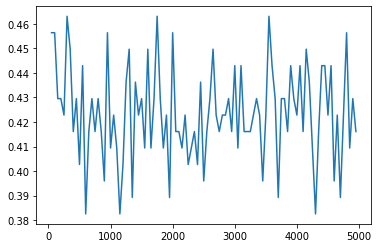

In [7]:
# plot accuracy by set size (I hope this is right...)
plt.plot(ln["Set Size"],ln["Accuracy"])

In [8]:
max(ln["Accuracy"])

0.4630872483221476

In [9]:
ln[ln["Accuracy"]==max(ln["Accuracy"])]

,Set Size,Accuracy,F1 Control,F1 Stressed
28,3550,0.463087,0.693467,0.0
64,1750,0.463087,0.693467,0.0
93,300,0.463087,0.690000,0.0
